In [2]:
from nbodykit.cosmology import Planck15
import numpy as np
import matplotlib.pyplot as plt

In [31]:
from vmad import Builder, autooperator, operator
import numpy as np
from vmad.core.stdlib.operators import mul, div, add, sub
from vmad.core.stdlib.operators import pow as power
from vmad.lib.unary import log, sinc, exp
from vmad.lib.linalg import reshape, broadcast_to
from nbodykit import cosmology


def normalize(r,Omega0_m, transfer='EH', kmin=1e-5, kmax=1e1):
    """
    The mass fluctuation within a sphere of radius ``r``, in
    units of :math:`h^{-1} Mpc` at ``redshift``.
    This returns :math:`\sigma`, where
    .. math::
        \sigma^2 = \int_0^\infty \frac{k^3 P(k,z)}{2\pi^2} W^2_T(kr) \frac{dk}{k},
    where :math:`W_T(x) = 3/x^3 (\mathrm{sin}x - x\mathrm{cos}x)` is
    a top-hat filter in Fourier space.
    The value of this function with ``r=8`` returns
    :attr:`sigma8`, within numerical precision.
    Parameters
    ----------
    r : float, array_like
        the scale to compute the mass fluctation over, in units of
        :math:`h^{-1} Mpc`
    kmin : float, optional
        the lower bound for the integral, in units of :math:`\mathrm{Mpc/h}`
    kmax : float, optional
        the upper bound for the integral, in units of :math:`\mathrm{Mpc/h}`
    """
    import mcfit
    from scipy.interpolate import InterpolatedUnivariateSpline as spline
    cosmo = cosmology.Planck15.match(Omega0_m=Omega0_m)
    k = np.logspace(np.log10(kmin), np.log10(kmax), 1024)
    if transfer=='EH':
        p= get_Pk_EH.build(cosmo=cosmo, z=0, k=k)
    elif transfer=='NWEH':
        p= get_Pk_NWEH.build(cosmo=cosmo, z=0, k=k)
    else:
        raise ValueError('transfer must be EH or NWEH')
    Pk= p.compute(init = dict(Omega0_m=Omega0_m),vout=['Pk'], return_tape=False)
    R, sigmasq = mcfit.TophatVar(k, lowring=True)(Pk, extrap=True)

    return spline(R, sigmasq)(r)**.5

@autooperator('omega_z, omega_lambda->growth')
def grow(omega_z, omega_lambda, z):
    pre_fac = mul((1+z)**-1, div(mul(5, omega_z), 2))
    inside = power(
        add(sub(power(omega_z, 4/7), omega_lambda),
            mul(add(1, div(omega_z,2)),
                add(1, div(omega_lambda,70)))),
        -1)
    return dict(growth=mul(pre_fac, inside))

@autooperator('omega0_m->omega_z')
def get_omega_z(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    num      = mul(omega0_m, (1+z)**3)
    denom    = omega0_l+ num
    return dict(omega_z = div(num, denom))

@autooperator('omega0_m->omega_lambda')
def get_omega_lambda(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    denom = add(omega0_l, mul(omega0_m, (1+z)**3))
    return dict(omega_lambda = div(omega0_l, denom))

@autooperator('Omega0_m->Pk')
def get_Pk_NWEH(Omega0_m, cosmo, z, k):

    Omega0_m = broadcast_to(Omega0_m, np.shape(k))
    Obh2 = cosmo.Omega0_b * cosmo.h**2
    Omh2 = mul(Omega0_m, power(cosmo.h, 2))
    f_baryon = div(cosmo.Omega0_b, Omega0_m)
    theta_cmb = cosmo.Tcmb0 / 2.7

    k_eq = mul(mul(0.0746, Omh2), power(theta_cmb,-2)) # units of 1/Mpc
    
    sound_horizon = div(mul(mul(cosmo.h, 44.5), log(div(9.83, Omh2))), np.sqrt(1 + 10 * Obh2** 0.75)) # in Mpc/h


    alpha_gamma = add(sub(1, mul(mul(0.328, log(mul(431,Omh2))), f_baryon)),\
                      mul(mul(0.38, log(mul(22.3,Omh2))), power(f_baryon, 2)))
    k = k * cosmo.h  # in 1/Mpc now
    ks = div(mul(k,sound_horizon), cosmo.h)    # units h^-2
    
    q = div(k, mul(13.41, k_eq))        # units Mpc^-2
    gamma_eff = mul(Omh2, add(alpha_gamma, div(sub(1,alpha_gamma), add(1, power(mul(0.43,ks),4))))) # Unitless?
    q_eff = div(mul(q,Omh2), gamma_eff)  # h^2 Mpc^-2

    L0 = log(add(2*np.e, mul(1.8, q_eff)))
    C0 = add(14.2, div(731.0, add(1, mul(62.5, q_eff))))

    T = div(L0, add(L0, mul(C0, power(q_eff,2))))

    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)
    omega_zs = get_omega_z(Omega0_m, 0)
    omega_lambdas = get_omega_lambda(Omega0_m, 0)
    growth_0 = grow(omega_zs, omega_lambdas, 0)
    factor = power(div(k,cosmo.h),cosmo.n_s)

    Pk = mul(mul(power(T, 2), div(power(growth_z, 2),power(growth_0,2))),factor)
    return dict(Pk=Pk)

@autooperator('a,b,q->c')
def f(a,b,q):
     return dict(c = div(a, add(a ,mul( b, power(q,2)))))

    

@autooperator('Omega0_m->Pk')
def get_Pk_NWEH(Omega0_m, cosmo, z, k):

    Omega0_m = broadcast_to(Omega0_m, np.shape(k))
    Obh2 = cosmo.Omega0_b * cosmo.h**2
    Omh2 = mul(Omega0_m, power(cosmo.h, 2))
    f_baryon = div(cosmo.Omega0_b, Omega0_m)
    theta_cmb = cosmo.Tcmb0 / 2.7

    k_eq = mul(mul(0.0746, Omh2), power(theta_cmb,-2)) # units of 1/Mpc
    
    sound_horizon = div(mul(mul(cosmo.h, 44.5), log(div(9.83, Omh2))), np.sqrt(1 + 10 * Obh2** 0.75)) # in Mpc/h


    alpha_gamma = add(sub(1, mul(mul(0.328, log(mul(431,Omh2))), f_baryon)),\
                      mul(mul(0.38, log(mul(22.3,Omh2))), power(f_baryon, 2)))
    k = k * cosmo.h  # in 1/Mpc now
    ks = div(mul(k,sound_horizon), cosmo.h)    # units h^-2
    
    q = div(k, mul(13.41, k_eq))        # units Mpc^-2
    gamma_eff = mul(Omh2, add(alpha_gamma, div(sub(1,alpha_gamma), add(1, power(mul(0.43,ks),4))))) # Unitless?
    q_eff = div(mul(q,Omh2), gamma_eff)  # h^2 Mpc^-2

    L0 = log(add(2*np.e, mul(1.8, q_eff)))
    C0 = add(14.2, div(731.0, add(1, mul(62.5, q_eff))))

    T = div(L0, add(L0, mul(C0, power(q_eff,2))))

    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)
    omega_zs = get_omega_z(Omega0_m, 0)
    omega_lambdas = get_omega_lambda(Omega0_m, 0)
    growth_0 = grow(omega_zs, omega_lambdas, 0)
    factor = power(div(k,cosmo.h),cosmo.n_s)

    Pk = mul(mul(power(T, 2), div(power(growth_z, 2),power(growth_0,2))),factor)
    return dict(Pk=Pk)    

@autooperator('Omega0_m->Pk')
def get_Pk_EH(Omega0_m, cosmo, z, k):
    Omega0_m = broadcast_to(Omega0_m, np.shape(k))
    Obh2 = mul(cosmo.Omega0_b, power(cosmo.h, 2))
    Omh2 = mul(Omega0_m, power(cosmo.h, 2))
    f_baryon = div(cosmo.Omega0_b, Omega0_m)
    theta_cmb = div(cosmo.Tcmb0 , 2.7)

    # z and wavenumber of equality
    z_eq = mul(mul(2.5e4, Omh2),power(theta_cmb, -4)) # this is 1 + z
    k_eq = mul(mul(0.0746, Omh2),power(theta_cmb ,-2)) # units of 1/Mpc

    # sound horizon and k_silk
    z_drag_b1 = mul(mul(0.313, power(Omh2, -0.419)), add(1, mul(0.607,power(Omh2, 0.674))))
    z_drag_b2 = mul(0.238, power(Omh2,0.223))
    z_drag    = mul(div(mul(1291, power(Omh2, 0.251)), add(1., mul(0.659, power(Omh2, 0.828)))), add(1., mul(z_drag_b1, power(Obh2, z_drag_b2))))



    r_drag = div(mul(mul(mul(31.5, Obh2), power(theta_cmb, -4)), 1000.), add(1,z_drag))
    r_eq   = div(mul(mul(mul(31.5, Obh2), power(theta_cmb, -4)), 1000.), add(1,z_eq))

    sound_horizon = mul(mul(div(2., mul(3.,k_eq)),power(div(6., r_eq), .5)), \
                    log(div(add(power(add(1,r_drag), .5), power(add(r_drag,r_eq), .5)), add(1, power(r_eq, .5)))))

    k_silk = mul(mul(mul(1.6,power( Obh2, 0.52)), power(Omh2,0.73)),add(1, power(mul(10.4,Omh2), -0.95)))

    # alpha_c
    alpha_c_a1 = mul(power(mul(46.9,Omh2),0.670 ), add(1, power(mul(32.1,Omh2), -0.532)))
    alpha_c_a2 = mul(power(mul(12.0,Omh2), 0.424), add(1, power(mul(45.0,Omh2), -0.582)))
    alpha_c = mul(power(alpha_c_a1, -f_baryon), power(alpha_c_a2 , power(-f_baryon,3)))

    # beta_c
    beta_c_b1 = div(0.944, add(1, power(mul(458,Omh2), -0.708)))
    beta_c_b2 = mul(0.395, power(Omh2, -0.0266))
    beta_c = div(1., add(1 , sub(mul(beta_c_b1, power(sub(1,f_baryon), beta_c_b2)), 1)))

    y = div(z_eq, add(1, z_drag))
    alpha_b_G = mul(y, \
                    add(mul(-6.,power(add(1,y), .5)),
                        mul(add(2.,mul(3.,y)),
                            log(div(add(power(add(1,y), .5),1),sub(power(add(1,y), .5),1))))))
    alpha_b = mul(mul(mul(2.07,  k_eq), sound_horizon), mul(power(add(1,r_drag),-0.75), alpha_b_G))

    beta_node = mul(8.41, power(Omh2, 0.435))
    beta_b    = add(add(0.5, f_baryon), mul(sub(3., mul(2.,f_baryon)),power( add(power(mul(17.2,Omh2), 2), 1 ), .5)))


    k = k * cosmo.h # now in 1/Mpc

    q = div(k, mul(13.41,k_eq))
    ks = mul(k,sound_horizon)

    T_c_ln_beta   = log(add(np.e, mul(mul(1.8,beta_c),q)))
    T_c_ln_nobeta = log(add(np.e, mul(1.8,q)));

    T_c_C_alpha   = add(div(14.2, alpha_c), div(386., add(1, mul(69.9,power( q, 1.08)))))


    T_c_C_noalpha = add(14.2,  div(386., add(1, mul(69.9, power(q, 1.08)))))


    T_c_f = div(1., add(1.,power(div(ks,5.4), 4)))


    T_c = add(mul(T_c_f, f(T_c_ln_beta, T_c_C_noalpha, q)), mul(sub(1,T_c_f), f(T_c_ln_beta, T_c_C_alpha,q)))


    s_tilde = mul(sound_horizon, power(add(1, power(div(beta_node,ks),3)), (-1./3.)))


    ks_tilde = mul(k,s_tilde)


    T_b_T0 = f(T_c_ln_nobeta, T_c_C_noalpha, q)


    T_b_1 = div(T_b_T0, add(1, power(div(ks,5.2),2 )))


    T_b_2 = mul(div(alpha_b, add(1, power(div(beta_b,ks),3 ))), exp(-power(div(k,k_silk), 1.4)))


    T_b = mul(sinc(div(ks_tilde,np.pi)), add(T_b_1, T_b_2))

    T = add(mul(f_baryon,T_b), mul(sub(1,f_baryon),T_c));
    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)
    omega_zs = get_omega_z(Omega0_m, 0)
    omega_lambdas = get_omega_lambda(Omega0_m, 0)
    growth_0 = grow(omega_zs, omega_lambdas, 0)

    factor = (k/cosmo.h)**cosmo.n_s

    Pk =mul(mul(power(T, 2), div(power(growth_z, 2),power(growth_0,2))),factor)
    return dict(Pk=Pk)

In [45]:


norm = normalize(r=8, Omega0_m=Planck15.Omega0_m,transfer='EH')
norm = (Planck15.sigma8/norm)**2

#transfer =  get_Pk_EH(Om0, cosmo=self.cosmo, z=0, k=self.k_s)

In [46]:
ks = np.logspace(-5,1,500)
p  = get_Pk_EH.build(cosmo=Planck15, z=0, k=ks)
Pk = p.compute(init = dict(Omega0_m=Planck15.Omega0_m),vout=['Pk'], return_tape=False)[0]*norm

In [47]:
Pk_ = Planck15.get_pk(ks,z=0)

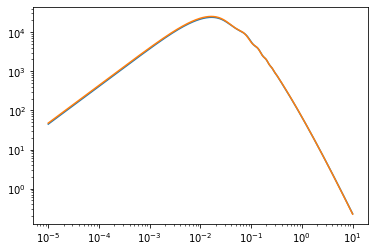

In [48]:
plt.loglog(ks, Pk)
plt.loglog(ks, Pk_)

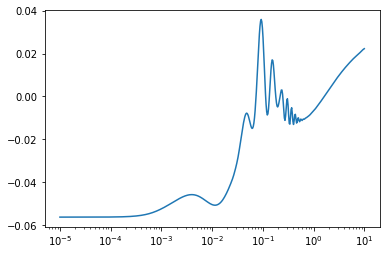

In [49]:
plt.semilogx(ks,(Pk-Pk_)/Pk_)

In [19]:
Planck15.Omega0_m, Planck15.Omega0_cdm, Planck15.Omega0_ncdm[0], Planck15.Omega0_b, Planck15.sigma8

(0.30890374144332966, 0.2589, 0.001403884157638176, 0.0486, 0.8158116144901115)

In [24]:
Planck15_=Planck15.match(Omega0_m=Planck15.Omega0_m+1e-2)
Planck15_s = Planck15_.match(sigma8=Planck15.sigma8)

In [25]:
Planck15_.Omega0_m, Planck15_.Omega0_cdm, Planck15_.Omega0_ncdm[0], Planck15_.Omega0_b,Planck15_.sigma8

(0.3189037414433297,
 0.267319512195122,
 0.001403884157638176,
 0.050180487804878056,
 0.8277773701476765)

In [26]:
Planck15_s.Omega0_m, Planck15_s.Omega0_cdm, Planck15_s.Omega0_ncdm[0], Planck15_s.Omega0_b,Planck15_s.sigma8

(0.3189037414433297,
 0.267319512195122,
 0.001403884157638176,
 0.050180487804878056,
 0.8158116144901117)

In [16]:
Planck15_.Omega0_cdm/Planck15_.Omega0_m, Planck15.Omega0_cdm/Planck15.Omega0_m

(0.8382451425162273, 0.8381251673751476)

In [17]:
Planck15_.Omega0_ncdm/Planck15_.Omega0_m, Planck15.Omega0_ncdm/Planck15.Omega0_m

(array([0.00440222]), array([0.00454473]))

In [18]:
Planck15_.Omega0_b/Planck15_.Omega0_m, Planck15.Omega0_b/Planck15.Omega0_m

(0.15735308584893257, 0.1573305644435387)

In [28]:
Planck15_=Planck15.clone(Omega0_cdm=Planck15.Omega0_cdm+1e-2)
Planck15_s = Planck15_.match(sigma8=Planck15.sigma8)

In [31]:
Planck15_s.Omega0_m, Planck15_s.Omega0_cdm, Planck15_s.Omega0_ncdm[0], Planck15_s.Omega0_b,Planck15_s.sigma8,Planck15_.sigma8

(0.31890374144332967,
 0.26890000000000003,
 0.001403884157638176,
 0.0486,
 0.815811614490111,
 0.8356492364234914)